# 에너지 빅데이터 활용 데이터 사이언스 콘테스트

## 전력수요예측 대회

- **작성일 : 2019-10-21**
- **팀명 : TEAM-EDA**
- **작성자 : 김현우, 이해중**

## 요약(Executive Summary)

./..

## 목적(Objectives)

본 대회에서는, 기존 전력 사용 기록과 기상 데이터 등 공공 데이터를 이용하여, 각 가정 및 회사의 시간별, 일별, 월별 전력 사용량을 예측합니다. 2018년 7월1일부터 2018년 11월 30일까지의 에너지 사용량을 예측합니다. 보다 정확히는 다음을 예측합니다.

 
- 2018년 7월 1일 00시부터 24시까지, 24시간, ‘시간당 전력사용량’ (24게)

- 2018년 7월 1일부터 7월10일까지, 10일간, ‘일간 전력사용량’ (10개)

- 2018년 7월부터 11월까지, 5개월간, ‘월간 전력사용량’ (5개)

 
즉 각 세대(또는 상가)당 39개(24개,10개,5개)의 값을 예측해야 합니다.

## 방법(Methods)

- **LSTM을 사용한 예측**

<img src="https://drive.google.com/uc?export=view&id=1grE7ej4N2y89A_mGTfNEBtWE8C2Ndb0Z" width="600" height="400">

## 데이터(Data)

### 데이터 기술

> **과거 16-18년도 당시 인천 기상 예측 데이터 제공**

1. **train.csv**

    - 국내(인천지역) 특정 지역의 모 아파트 및 모 상가의 전력사용량. (1300호)  
    - 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량  


2. **test.csv**

    - 국내(인천지역) 특정 지역의 모 아파트 및 모 상가의 전력사용량. (200호)  
    - 2017년 7월 1일 00시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량
    - train의 세대와 다른 세대


3. **submission.csv**
    - test셋에 제시된 세대(상가)에 대한 예측값들을 제출하는 포맷




### 중요변수 기술

> **시간(TimeSeries)** : O  
> 
> **기상 데이터** : X


### 데이터 크기도 기술

> 


In [2]:
import pandas as pd
from tqdm import tqdm_notebook 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (14,5)
plt.rcParams['axes.grid'] = True 

train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')
submission_data = pd.read_csv('input/submission_1002.csv', index_col = 'meter_id').astype('float')

# 기상 데이터 불러오기
weather_data_hour = pd.read_csv('input/인천_시간별__기상자료(16-18)_축소__7월1일.csv', engine = 'python')
weather_data_hour['일시'] = pd.to_datetime(weather_data_hour.일시)
weather_data_hour = weather_data_hour.set_index('일시')

weather_data_day = pd.read_csv('input/인천_일별_기상자료(16-18)_축소.csv', engine = 'python')
weather_data_day['일시'] = pd.to_datetime(weather_data_day.일시)
weather_data_day = weather_data_day.set_index('일시')

# weather_data_month = pd.read_csv('input/인천_월별_기상자료(16-18)_축소.csv', engine = 'python')
# weather_data_month['일시'] = pd.to_datetime(weather_data_month.일시)
# weather_data_month = weather_data_month.set_index('일시')

# Train Data datetime 변경
train_data['Time'] = pd.to_datetime(train_data.Time)
train_data = train_data.set_index('Time')

# Test Data datetime 변경
test_data['Time'] = pd.to_datetime(test_data.Time)
test_data = test_data.set_index('Time')

In [7]:
print('train shape : ',train_data.shape)
print('test shape : ',test_data.shape)
print('submission shape : ',submission_data.shape)
print("weather_data_hour :", weather_data_hour.shape)
print("weather_data_day :", weather_data_day.shape)

train shape :  (16909, 1300)
test shape :  (8760, 200)
submission shape :  (200, 39)
weather_data_hour : (17088, 8)
weather_data_day : (721, 4)


In [11]:
data_hour.head()

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,...,X107,X230,지점,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),날씨,전운량(10분위)
Time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021,NaN,112,22.8,0.0,2.1,91.0,0.0,0.0,8.0
2017-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021,NaN,112,22.7,0.0,2.4,92.0,0.0,0.0,8.0
2017-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021,NaN,112,22.3,0.0,1.9,95.0,0.0,0.0,8.0
2017-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020,NaN,112,22.0,0.0,1.8,95.0,0.0,0.0,8.0
2017-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021,NaN,112,21.8,0.0,2.4,95.0,0.0,0.0,8.0



### EDA나 시각화 결과도 필요시 기술

#### test data 전처리

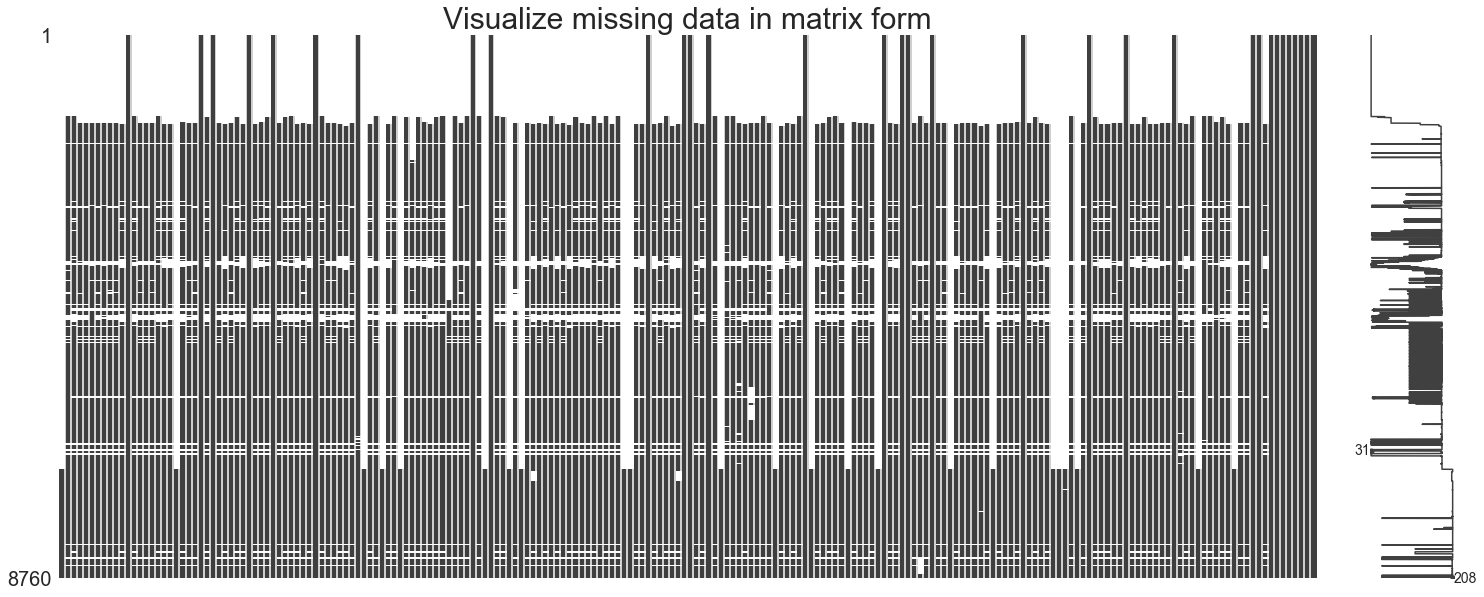

In [12]:
import missingno as msno

# 매트리스 형태로 누락데이터를 시각화하는 명령
# 누락 데이터는 흰색
# 가장 오른쪽에 있는 것은 스파크라인(spark line) : 각 행의 데이터 완성도를 표현한다.
msno.matrix(data_hour)
plt.title("Visualize missing data in matrix form", fontsize=30)
plt.show()

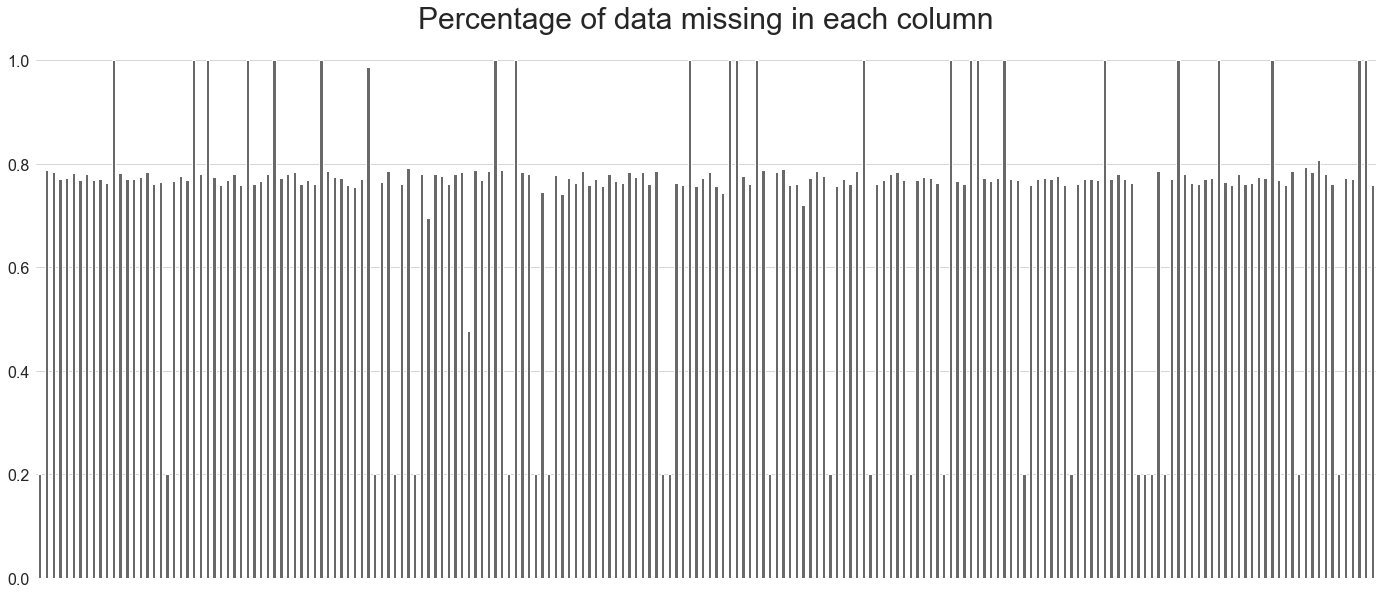

In [15]:
# 각 열의 누락데이터가 얼마나 존재하는지에 대해서만 시각화
msno.bar(test_data)
plt.title("Percentage of data missing in each column", fontsize=30)
plt.show()

> **Problem 1** : Test Data의 결측치가 너무 많다.  

> **Action 1** : `GroupBy`를 사용하여 **평균값** 대입 (월(0), 화(1), 수(2), 목(3), 금(4), 토(5), 일(6) /Hour(0~23)의 조합)  
  
> 
> **Example**: 
>
>| 요일 | 시간 | 요일-시간 (Period) |
| :--: | :--: | :--: |
| 월요일 | 00:00:00 | 0-0 |
| 월요일 | 01:00:00 | 0-1 | 
| 월요일 | 02:00:00 | 0-2 | 
| $\vdots$ | $\vdots$ | $\vdots$ |
| 일요일 | 22:00:00 | 6-22 |
| 일요일 | 23:00:00 | 6-23 |

In [16]:
# 파생변수 설정 : 요일-시간(Period) 으로 GroupBy를 위한 키값 생성
data_hour['Period'] = data_hour.index.weekday.map(str) + '-' + test_data.index.hour.map(str)

# Column 별 위의 방법을 사용하여 결측치 대입
test_data_prp1 = data_hour.reset_index()
test_data_prp2 = test_data_prp1.groupby('Period').apply(lambda g: g.fillna(g.mean())).set_index('Time').sort_index()
test_data_prp2.drop(['Period'], axis='columns', inplace=True)

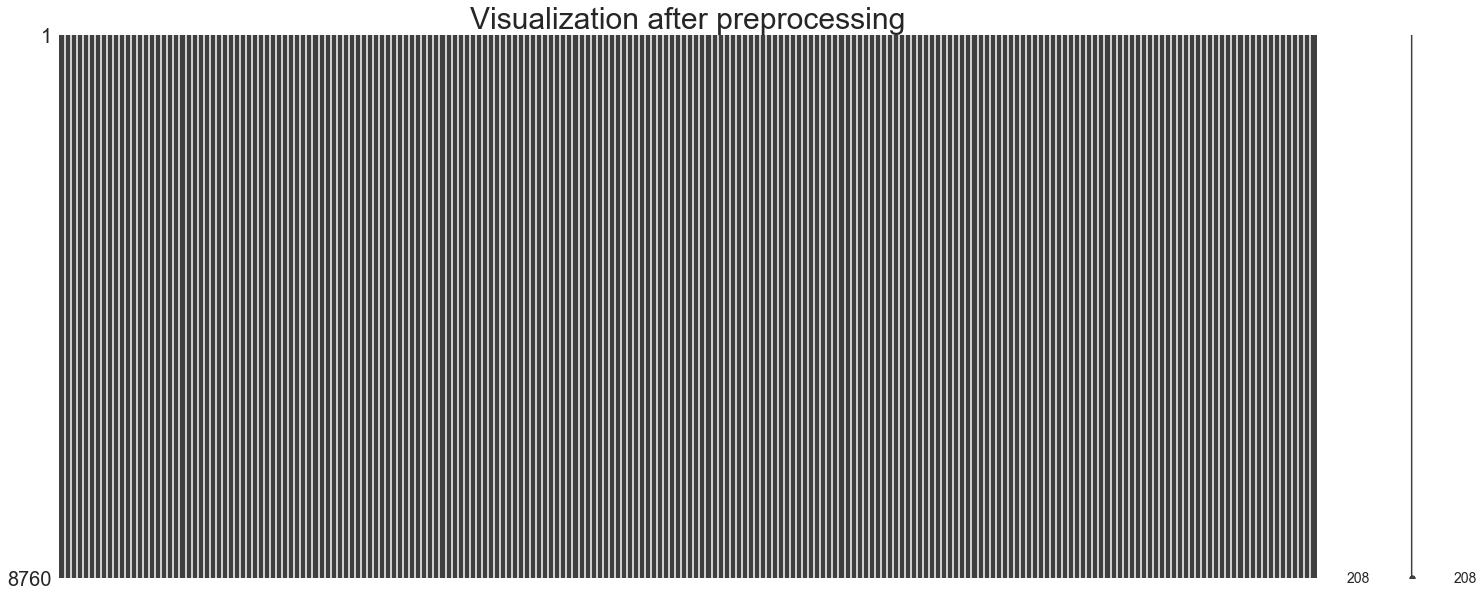

In [17]:
msno.matrix(test_data_prp2)
plt.title("Visualization after preprocessing", fontsize=30)
plt.show()

In [22]:
test_data_prp2 = test_data_prp2.round(3)
test_data_prp2.head(5)

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,...,X107,X230,지점,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),날씨,전운량(10분위)
Time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,1.213,0.356,0.243,0.279,0.184,0.140,0.274,0.246,0.055,0.150,...,0.021,0.345,112,22.8,0.0,2.1,91.0,0.0,0.0,8.0
2017-07-01 01:00:00,1.212,0.542,0.252,0.338,0.195,0.166,0.376,0.281,0.072,0.208,...,0.021,0.347,112,22.7,0.0,2.4,92.0,0.0,0.0,8.0
2017-07-01 02:00:00,1.227,0.464,0.269,0.326,0.192,0.150,0.345,0.282,0.068,0.226,...,0.021,0.333,112,22.3,0.0,1.9,95.0,0.0,0.0,8.0
2017-07-01 03:00:00,1.207,0.416,0.258,0.317,0.190,0.144,0.347,0.310,0.068,0.210,...,0.020,0.313,112,22.0,0.0,1.8,95.0,0.0,0.0,8.0
2017-07-01 04:00:00,1.473,0.485,0.314,0.330,0.190,0.144,0.328,0.284,0.072,0.219,...,0.021,0.318,112,21.8,0.0,2.4,95.0,0.0,0.0,8.0


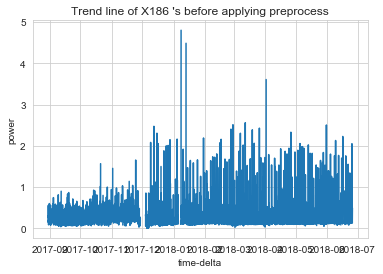

In [24]:
# 전처리 전 : 186X의 Trend

x = 'X186'
start = 0
dt = 24*360
plt.title('Trend line of '+ x + " 's before applying preprocess")
plt.plot(test_data[x][start:start+dt])
plt.ylabel("power")
plt.xlabel("time-delta")
plt.show()

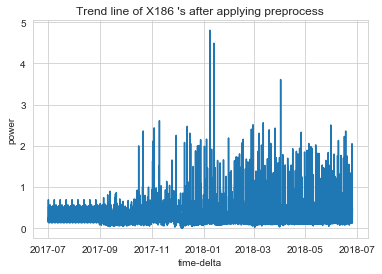

In [25]:
# 전처리 후 : 186의 Trend

x = 'X186'
start = 0
dt = 24*360
plt.title('Trend line of '+ x + " 's after applying preprocess")
plt.plot(test_data_prp2[x][start:start+dt])
plt.ylabel("power")
plt.xlabel("time-delta")
plt.show()

#### Train / Test 데이터 만들기

<img src="https://drive.google.com/uc?export=view&id=1hMaf6oHdNOGOA96u7TEwFVvVhv-Eu4m3" width="800" height="400">

In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from tensorflow.keras import layers
import tensorflow as tf
# import check_util.checker as checker
from IPython.display import clear_output
import os
import time
import glob
import csv

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()
print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 1.14.0
GPU 사용 가능 여부: True


In [27]:
def make_dataset(data, seq_length=480, target_delay=24, strides=5,
                 mode='train', train_mean=None, train_std=None):
    '''
        각 인수에 대한 설명은 위의 'Dataset만들기' 설명을 참고하세요.
    '''
    assert mode in ['train', 'val', 'test']
    if mode is not 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    if mode is 'train':
        mean = np.mean(data , axis = 0)   
        std = np.std(data, axis = 0)    
    else: 
        mean = train_mean
        std = train_std
    data = (data - mean)/std

    
    # 입력, 타겟 데이터 생성
    train_sequence = []
    train_target = []
    # Test 데이터 생성
    test_sequence = []
    for index in range(len(data)):
        if index % strides == 0 and index <= (len(data) - seq_length - target_delay):
            train_sequence.append(data[index:index+seq_length])    
            train_target.append(data[index+seq_length+target_delay-1][0])
        elif index > (len(data) - seq_length - target_delay) and index <= (len(data) - seq_length):
            test_sequence.append(data[index:index+seq_length])
        
    if mode is 'train':
        return np.array(train_sequence), np.array(train_target), mean, std, np.array(test_sequence)
    else:
        return np.array(sequence), np.array(target)

In [104]:
# 하드코딩 부분...-> 모든 데이터 시도 필요!
train_data_np = np.array(test_data_prp2[['X5','기온(°C)', '강수량(mm)', '습도(%)']])
# train_data_np = train_data_np.reshape(len(test_data_prp2['X5']),1)
#train_data_np = np.array(test_data_prp2[['X5','기온(°C)', '강수량(mm)', '습도(%)', '적설(cm)', '날씨', '전운량(10분위)']])

In [105]:
np.shape(train_data_np)

(8760, 4)

In [161]:
seq_length = 24*20
target_delay = 24
strides = 2
train_sequences, train_labels, train_mean, train_std, test_sequences = make_dataset(
    train_data_np, seq_length, target_delay, strides, mode='train')

#### 하이퍼파라미터 세팅

In [162]:
batch_size = 128*4 # 128로 한 경우 시간이 더 오래 소요됨
max_epochs = 30
learning_rate = 3e-4
hidden_sizes = [30, 30]  # hidden_sizes must be a list

In [163]:
# batch_size = 128*4 # 128로 한 경우 시간이 더 오래 소요됨
# max_epochs = 30
# learning_rate = 3e-4
# hidden_sizes = [30, 30]  # hidden_sizes must be a list

#### Input pipeline 만들기

In [164]:
# shuffle의 인자로 buffer_size가 필요한데 이는 전체 데이터셋 갯수로 하는게 좋습니다.
N = BUFFER_SIZE = len(train_sequences)  # number of samples in train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sequences, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)

#### LSTM 네트워크 설계

우리는 LSTM 구조를 통해 기온 예측을 모델을 학습시킬 것입니다. 설계할 네트워크의 대략적인 개요는 아래 그림과 같습니다.

<img src="http://drive.google.com/uc?export=view&id=1AjxdDivdX23DSdubayKhAAcXmWfRBSvb"  width="800px" height="400px" />

In [165]:
# GPU 사용 가능한지 체크, 해당 블록은 실행만 하면 됩니다.
if tf.test.is_gpu_available():
    print("Using 'tf.keras.layers.CuDNNLSTM'")
    rnn_layer = tf.keras.layers.CuDNNLSTM
else:
    print("Using `tf.keras.layers.LSTM`")
    rnn_layer = tf.keras.layers.LSTM

Using 'tf.keras.layers.CuDNNLSTM'


In [166]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self, hidden_sizes):
        super(SimpleLSTM, self).__init__()
        assert isinstance(hidden_sizes, list)
        ## 코드 시작 ##
        self.hidden_sizes = hidden_sizes         
        self.num_layers = len(hidden_sizes)   
        ## 코드 종료 ##
        
        # RNN 층 쌓기
        ## 코드 시작 ##
        self.rnn = []
        for i in range(self.num_layers-1):
            self.rnn.append(layers.CuDNNLSTM(units=hidden_sizes[i], return_sequences=True))  
        self.rnn.append(layers.CuDNNLSTM(hidden_sizes[-1], return_sequences=False))       
        ## 코드 종료 ##
        
        # Dense 층 만들기
        ## 코드 시작 ##
        self.dense = layers.Dense(units=1, input_shape=(hidden_sizes[-1],))
        ## 코드 종료 ##

    def call(self, x):
        # 입력 데이터인 x 가 RNN 층 > Dense 층 통과
        # 코드 시작
        for i in range(self.num_layers):
            x = self.rnn[i](x)       
        x = self.dense(x)             
        ## 코드 종료 ##

        return x

In [167]:
model = SimpleLSTM(hidden_sizes)
for step, (sequences, targets) in enumerate(train_dataset.take(1)):
    predictions = model(sequences)

In [168]:
model.summary()

Model: "simple_lstm_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_12 (CuDNNLSTM)    multiple                  4320      
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    multiple                  7440      
_________________________________________________________________
dense_6 (Dense)              multiple                  31        
Total params: 11,791
Trainable params: 11,791
Non-trainable params: 0
_________________________________________________________________


####  Loss function, Optimizer 정의

In [169]:
## 코드 시작 ##
loss_object = tf.keras.losses.MeanAbsolutePercentageError()

# MAPE
# def loss_object(A, F):
#     return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

optimizer =  tf.train.AdamOptimizer(learning_rate)
## 코드 종료 ##

# record loss for every epoch
mean_loss = tf.keras.metrics.Mean("loss")

#### train 함수 정의

In [170]:
def train_step(model, sequences, targets):
    ## 코드 시작 ##
    with tf.GradientTape() as tape:
        predictions = model(sequences)
        loss_value = loss_object(tf.squeeze(predictions), targets)

    gradients = tape.gradient(target=loss_value, sources=model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.variables))
    ## 코드 종료 ##

    return loss_value

In [171]:
print_steps = 30

#### Test 하기

In [172]:
def main(model, train_dataset, print_steps):
    print('Start training..')
    num_batches_per_epoch = len(list(train_dataset))
    global_step = 0
    best_loss = 999999.

    for epoch in range(max_epochs):
        for step, (sequences, targets) in enumerate(train_dataset):

            start_time = time.time()
            # train_step 함수 사용하여 loss 구하기
            ## 코드 시작 ##
            loss_value = train_step(model, sequences, targets)
            
            ## 코드 종료 ##
            mean_loss(loss_value)
            global_step += 1
            
            if global_step % print_steps == 0:
                duration = time.time() - start_time
                examples_per_sec = batch_size / float(duration)
                clear_output(wait=True)
                print("Epochs: [{}/{}] step: [{}/{}] loss: {:.4g}  ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                    epoch+1, max_epochs, step+1, num_batches_per_epoch,
                    mean_loss.result(), examples_per_sec, duration))

            mean_loss.reset_states()


    print('training done..')

In [173]:
main(model, train_dataset, print_steps)

Epochs: [30/30] step: [9/9] loss: 1041  (7214.09 examples/sec; 0.071 sec/batch)
training done..


In [174]:
for i in range(10):
    data_idx = np.random.randint(len(train_sequences))
    pred = model(train_sequences[data_idx:data_idx+1, :, :]).numpy()[0, 0]
    # 예측 전력량을 normalization 이전 상태로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    # 실제 전력량을 normalization 이전 상태로 되돌리는 작업
    target = float(train_labels[data_idx] * train_std[0] + train_mean[0])
    print('예측 전력량: {:.3f} / 실제 전력량: {:.3f} / 차이: {:.3f}'.format(pred, target, pred - target))

예측 전력량: 5.692 / 실제 전력량: 5.470 / 차이: 0.222
예측 전력량: 5.742 / 실제 전력량: 5.669 / 차이: 0.073
예측 전력량: 5.750 / 실제 전력량: 5.568 / 차이: 0.182
예측 전력량: 5.661 / 실제 전력량: 5.640 / 차이: 0.021
예측 전력량: 5.644 / 실제 전력량: 5.870 / 차이: -0.226
예측 전력량: 5.640 / 실제 전력량: 5.473 / 차이: 0.167
예측 전력량: 5.745 / 실제 전력량: 5.037 / 차이: 0.708
예측 전력량: 5.677 / 실제 전력량: 5.838 / 차이: -0.161
예측 전력량: 5.688 / 실제 전력량: 6.056 / 차이: -0.368
예측 전력량: 5.724 / 실제 전력량: 5.325 / 차이: 0.399


In [175]:
start_hour = 'X2018_7_1_'
start_day = 'X2018_7_'
start_month = 'X2018_'

target_label = {}

for i in range(len(test_sequences)):
    pred = model(test_sequences[i:i+1, :, :]).numpy()[0, 0]
    # 예측 전력량을 normalization 이전 상태로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    print('X2018_7_1_'+str(i+1)+' 예측 전력량: {:.3f}'.format(pred))
    #target_label.append(round(pred, 6))
    target_label[start_hour + str(i+1) + 'h'] = round(pred, 6)

X2018_7_1_1 예측 전력량: 5.736
X2018_7_1_2 예측 전력량: 5.735
X2018_7_1_3 예측 전력량: 5.733
X2018_7_1_4 예측 전력량: 5.729
X2018_7_1_5 예측 전력량: 5.727
X2018_7_1_6 예측 전력량: 5.725
X2018_7_1_7 예측 전력량: 5.725
X2018_7_1_8 예측 전력량: 5.728
X2018_7_1_9 예측 전력량: 5.729
X2018_7_1_10 예측 전력량: 5.732
X2018_7_1_11 예측 전력량: 5.735
X2018_7_1_12 예측 전력량: 5.739
X2018_7_1_13 예측 전력량: 5.744
X2018_7_1_14 예측 전력량: 5.752
X2018_7_1_15 예측 전력량: 5.751
X2018_7_1_16 예측 전력량: 5.750
X2018_7_1_17 예측 전력량: 5.750
X2018_7_1_18 예측 전력량: 5.749
X2018_7_1_19 예측 전력량: 5.746
X2018_7_1_20 예측 전력량: 5.746
X2018_7_1_21 예측 전력량: 5.746
X2018_7_1_22 예측 전력량: 5.743
X2018_7_1_23 예측 전력량: 5.745
X2018_7_1_24 예측 전력량: 5.747


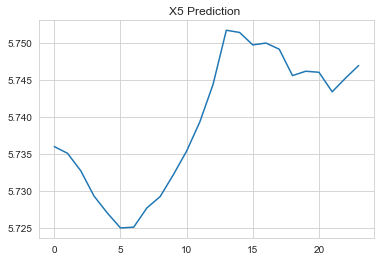

In [177]:
plt.plot(list(target_label.values()))
plt.title("X5 Prediction ")
plt.show()

##### X2018_7_1_1 ~ X2018_7_1_24 예측하는 부분

In [191]:
submission_data = pd.read_csv('input/submission_1002.csv', index_col = 'meter_id').astype('float')

In [196]:
from datetime import datetime, timedelta # 시간 데이터 처리

# 제출할 csv 읽어오기
submission_data = pd.read_csv('input/submission_1002.csv', index_col = 'meter_id').astype('float')

# Parameter 설정 부분
batch_size = 128*4 # 128로 한 경우 시간이 더 오래 소요됨
max_epochs = 30
learning_rate = 3e-4
hidden_sizes = [15, 15]  # hidden_sizes must be a list

# 입력 Data Set 설정 부분 
seq_length = 24*20
target_delay = 24
strides = 2

for i in tqdm_notebook(list(test_data_prp2.columns)):
    '''
    X2018_7_1_1 ~ X2018_7_1_24 예측하는 부분
    '''
    # X_계측기 고유 번호 
    # 각 계측기(X)에 해당하는 데이터를 numpy array로 변형
    train_data_np = np.array(test_data_prp2[[i,'기온(°C)', '강수량(mm)', '습도(%)']])
    # train_data_np = train_data_np.reshape(len(test_data_prp2[i]),1)
    
    # Train(train_sequences, train_labels) 및 Test(test_sequences) 할 수 있도록 데이터 변형
    train_sequences, train_labels, train_mean, train_std, test_sequences = make_dataset(
        train_data_np, seq_length, target_delay, strides, mode='train')
    
    # input pipeline
    N = BUFFER_SIZE = len(train_sequences)  # number of samples in train_dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_sequences, train_labels))
    train_dataset = train_dataset.shuffle(BUFFER_SIZE)
    train_dataset = train_dataset.batch(batch_size)    
    
    print("{0} 의 X2018_7_1_1h ~ X2018_7_1_24h 예측 모델 학습 시작".format(i))
    
    # model 학습
    
    model = SimpleLSTM(hidden_sizes) # 차이 비교해보기
    main(model, train_dataset, print_steps)
    
    # column 매핑을 위한 변수 초기화
    start_hour = 'X2018_7_1_'
    
    print("{0} 의 X2018_7_1_1h ~ X2018_7_1_24h 예측 모델 학습 종료".format(i))
    
    # target label 생성
    target_label = {}

    for j in range(len(test_sequences)):
        pred = model(test_sequences[j:j+1, :, :]).numpy()[0, 0]
        # 예측 전력량을 normalization 이전 상태로 되돌리는 작업
        pred = pred * train_std[0] + train_mean[0]
        
        print('X2018_7_1_'+str(j+1)+' 예측 전력량: {:.3f}'.format(pred))
        
        target_label[start_hour + str(j+1) + 'h'] = round(pred, 6)
        
    # Test 값 저장하는 과정
    submission_data.loc[i, 'X2018_7_1_1h':'X2018_7_1_24h'] = list(target_label.values())
    submission_data.loc[i]
    
print("완료")

Epochs: [30/30] step: [9/9] loss: 230.5  (7111.13 examples/sec; 0.072 sec/batch)
training done..
전운량(10분위) 의 X2018_7_1_1h ~ X2018_7_1_24h 예측 모델 학습 종료
X2018_7_1_1 예측 전력량: 6.750
X2018_7_1_2 예측 전력량: 6.757
X2018_7_1_3 예측 전력량: 6.774
X2018_7_1_4 예측 전력량: 6.800
X2018_7_1_5 예측 전력량: 6.833
X2018_7_1_6 예측 전력량: 6.871
X2018_7_1_7 예측 전력량: 6.912
X2018_7_1_8 예측 전력량: 6.952
X2018_7_1_9 예측 전력량: 6.989
X2018_7_1_10 예측 전력량: 7.029
X2018_7_1_11 예측 전력량: 7.059
X2018_7_1_12 예측 전력량: 7.074
X2018_7_1_13 예측 전력량: 7.078
X2018_7_1_14 예측 전력량: 7.051
X2018_7_1_15 예측 전력량: 7.023
X2018_7_1_16 예측 전력량: 6.985
X2018_7_1_17 예측 전력량: 6.938
X2018_7_1_18 예측 전력량: 6.887
X2018_7_1_19 예측 전력량: 6.832
X2018_7_1_20 예측 전력량: 6.772
X2018_7_1_21 예측 전력량: 6.712
X2018_7_1_22 예측 전력량: 6.655
X2018_7_1_23 예측 전력량: 6.594
X2018_7_1_24 예측 전력량: 6.552

완료


In [214]:
test_data_prp2.head()

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,...,X107,X230,지점,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),날씨,전운량(10분위)
Time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,1.213,0.356,0.243,0.279,0.184,0.140,0.274,0.246,0.055,0.150,...,0.021,0.345,112,22.8,0.0,2.1,91.0,0.0,0.0,8.0
2017-07-01 01:00:00,1.212,0.542,0.252,0.338,0.195,0.166,0.376,0.281,0.072,0.208,...,0.021,0.347,112,22.7,0.0,2.4,92.0,0.0,0.0,8.0
2017-07-01 02:00:00,1.227,0.464,0.269,0.326,0.192,0.150,0.345,0.282,0.068,0.226,...,0.021,0.333,112,22.3,0.0,1.9,95.0,0.0,0.0,8.0
2017-07-01 03:00:00,1.207,0.416,0.258,0.317,0.190,0.144,0.347,0.310,0.068,0.210,...,0.020,0.313,112,22.0,0.0,1.8,95.0,0.0,0.0,8.0
2017-07-01 04:00:00,1.473,0.485,0.314,0.330,0.190,0.144,0.328,0.284,0.072,0.219,...,0.021,0.318,112,21.8,0.0,2.4,95.0,0.0,0.0,8.0


##### X2018_7_1 ~ X2018_7_10 예측하는 부분

> input : **전력량**

In [218]:
test_data_prp2.drop(['지점', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '적설(cm)', '날씨', '전운량(10분위)'], axis='columns', inplace=True)
test_data_prp2_day = test_data_prp2.resample('D').sum()

In [221]:
test_data_prp2_day.head(10)

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,...,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
Time,,,,,,,,,,,,,,,,,,,,,
2017-07-01,34.612,13.105,7.891,8.019,8.314,5.338,10.146,8.170,2.153,6.599,...,6.070,6.273,8.622,8.562,9.428,6.952,5.899,28.951,0.500,9.163
2017-07-02,36.942,15.462,8.729,8.192,8.848,5.559,12.005,8.518,2.371,6.416,...,5.604,7.136,8.681,9.345,4.278,7.383,5.769,77.281,0.500,9.319
2017-07-03,26.258,11.374,8.185,8.113,8.533,5.730,11.519,8.722,2.245,5.861,...,5.437,5.232,8.279,7.669,6.022,6.067,5.862,14.870,0.499,9.347
2017-07-04,36.449,10.294,8.157,7.853,8.975,5.459,9.432,8.251,2.435,5.759,...,5.363,4.523,7.989,7.487,4.064,5.945,5.667,26.778,0.499,8.856
2017-07-05,38.996,11.417,8.076,7.848,8.504,5.499,9.333,8.197,2.449,5.997,...,5.401,4.480,7.733,7.006,3.933,6.077,5.704,26.452,0.499,8.650
2017-07-06,37.384,12.296,7.976,7.819,8.543,5.487,9.436,8.367,2.391,6.246,...,5.374,4.320,7.973,7.153,4.800,5.883,5.414,13.426,0.499,8.837
2017-07-07,36.245,10.864,8.062,8.228,8.478,5.105,9.616,8.313,2.237,5.697,...,5.411,4.162,8.119,7.119,4.101,5.985,5.580,24.481,0.499,8.826
2017-07-08,34.612,13.105,7.891,8.019,8.314,5.338,10.146,8.170,2.153,6.599,...,6.070,6.273,8.622,8.562,9.428,6.952,5.899,24.987,0.501,9.163
2017-07-09,36.942,15.462,8.729,8.192,8.848,5.559,12.005,8.518,2.371,6.416,...,5.604,7.136,8.681,9.345,4.278,7.383,5.769,77.895,0.500,9.319


In [222]:
def make_dataset_day(data, seq_length=480, target_delay=24, strides=5,
                 mode='train', train_mean=None, train_std=None):
    '''
        각 인수에 대한 설명은 위의 'Dataset만들기' 설명을 참고하세요.
    '''
    assert mode in ['train', 'val', 'test']
    if mode is not 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    if mode is 'train':
        mean = np.mean(data , axis = 0)   
        std = np.std(data, axis = 0)    
    else: 
        mean = train_mean
        std = train_std
    data = (data - mean)/std

    
    # 입력, 타겟 데이터 생성
    train_sequence = []
    train_target = []
    # Test 데이터 생성
    test_sequence = []
    for index in range(len(data)):
        if index % strides == 0 and index <= (len(data) - seq_length - target_delay):
            train_sequence.append(data[index:index+seq_length])    
            train_target.append(data[index+seq_length+target_delay-1])
        elif index > (len(data) - seq_length - target_delay) and index <= (len(data) - seq_length):
            test_sequence.append(data[index:index+seq_length])
        
    if mode is 'train':
        return np.array(train_sequence), np.array(train_target), mean, std, np.array(test_sequence)
    else:
        return np.array(sequence), np.array(target)

In [224]:
from datetime import datetime, timedelta # 시간 데이터 처리

# 제출할 csv 읽어오기
# submission_data = pd.read_csv('input/submission_1002.csv', index_col = 'meter_id').astype('float')

# Parameter 설정 부분
batch_size = 128*4 # 128로 한 경우 시간이 더 오래 소요됨
max_epochs = 30
learning_rate = 3e-4
hidden_sizes = [15, 15]  # hidden_sizes must be a list

# 입력 Data Set 설정 부분 
seq_length = 7*4
target_delay = 10
strides = 1

for i in tqdm_notebook(list(test_data_prp2_day.columns)):
    '''
    X2018_7_1_1 ~ X2018_7_1_24 예측하는 부분
    '''
    # X_계측기 고유 번호 
    # 각 계측기(X)에 해당하는 데이터를 numpy array로 변형
    train_data_np = np.array(test_data_prp2_day[i])
    train_data_np = train_data_np.reshape(len(test_data_prp2_day[i]),1)
    
    # Train(train_sequences, train_labels) 및 Test(test_sequences) 할 수 있도록 데이터 변형
    train_sequences, train_labels, train_mean, train_std, test_sequences = make_dataset_day(
        train_data_np, seq_length, target_delay, strides, mode='train')
    
    # input pipeline
    N = BUFFER_SIZE = len(train_sequences)  # number of samples in train_dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_sequences, train_labels))
    train_dataset = train_dataset.shuffle(BUFFER_SIZE)
    train_dataset = train_dataset.batch(batch_size)    
    
    print("{0} 의 X2018_7_1_d ~ X2018_7_10_d 예측 모델 학습 시작".format(i))
    
    # model 학습
    
    model = SimpleLSTM(hidden_sizes) # 차이 비교해보기
    main(model, train_dataset, print_steps)
    
    # column 매핑을 위한 변수 초기화
    start_day = 'X2018_7_'
    
    print("{0} 의 X2018_7_1_d ~ X2018_7_10_d 예측 모델 학습 종료".format(i))
    
    # target label 생성
    target_label = {}

    for j in range(len(test_sequences)):
        pred = model(test_sequences[j:j+1, :, :]).numpy()[0, 0]
        # 예측 전력량을 normalization 이전 상태로 되돌리는 작업
        pred = pred * train_std[0] + train_mean[0]
        
        print('X2018_7_'+str(j+1)+' 예측 전력량: {:.3f}'.format(pred))
        
        target_label[start_day + str(j+1) + 'd'] = round(pred, 6)
        
    # Test 값 저장하는 과정
    submission_data.loc[i, 'X2018_7_1_d':'X2018_7_10_d'] = list(target_label.values())
    
print("완료")

Epochs: [30/30] step: [1/1] loss: 501.2  (20480.70 examples/sec; 0.025 sec/batch)
training done..
X230 의 X2018_7_1_d ~ X2018_7_10_d 예측 모델 학습 종료
X2018_7_1 예측 전력량: 8.632
X2018_7_2 예측 전력량: 8.665
X2018_7_3 예측 전력량: 8.632
X2018_7_4 예측 전력량: 8.602
X2018_7_5 예측 전력량: 8.592
X2018_7_6 예측 전력량: 8.599
X2018_7_7 예측 전력량: 8.636
X2018_7_8 예측 전력량: 8.665
X2018_7_9 예측 전력량: 8.657
X2018_7_10 예측 전력량: 8.704

완료


##### X2018_7 ~ X2018_11 예측하는 부분

> input : **전력량**

In [226]:
test_data_prp2_month = test_data_prp2.resample('M').sum()

In [227]:
def make_dataset_month(data, seq_length=480, target_delay=24, strides=5,
                       mode='train', train_mean=None, train_std=None):
    '''
        각 인수에 대한 설명은 위의 'Dataset만들기' 설명을 참고하세요.
    '''
    assert mode in ['train', 'val', 'test']
    if mode is not 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    if mode is 'train':
        mean = np.mean(data , axis = 0)   
        std = np.std(data, axis = 0)    
    else: 
        mean = train_mean
        std = train_std
    data = (data - mean)/std

    
    # 입력, 타겟 데이터 생성
    train_sequence = []
    train_target = []
    # Test 데이터 생성
    test_sequence = []
    for index in range(len(data)):
        if index % strides == 0 and index <= (len(data) - seq_length - target_delay):
            train_sequence.append(data[index:index+seq_length])    
            train_target.append(data[index+seq_length+target_delay-1])
        elif index > (len(data) - seq_length - target_delay) and index <= (len(data) - seq_length):
            test_sequence.append(data[index:index+seq_length])
        
    if mode is 'train':
        return np.array(train_sequence), np.array(train_target), mean, std, np.array(test_sequence)
    else:
        return np.array(sequence), np.array(target)

In [229]:
from datetime import datetime, timedelta # 시간 데이터 처리

# 제출할 csv 읽어오기
# submission_data = pd.read_csv('input/submission_1002.csv', index_col = 'meter_id').astype('float')

# Parameter 설정 부분
batch_size = 128*4 # 128로 한 경우 시간이 더 오래 소요됨
max_epochs = 30
learning_rate = 3e-4
hidden_sizes = [15, 15]  # hidden_sizes must be a list

# 입력 Data Set 설정 부분 
seq_length = 4
target_delay = 5
strides = 1

for i in tqdm_notebook(list(test_data_prp2_month.columns)):
    '''
    X2018_7_1_1 ~ X2018_7_1_24 예측하는 부분
    '''
    # X_계측기 고유 번호 
    # 각 계측기(X)에 해당하는 데이터를 numpy array로 변형
    train_data_np = np.array(test_data_prp2_month[i])
    train_data_np = train_data_np.reshape(len(test_data_prp2_month[i]),1)
    
    # Train(train_sequences, train_labels) 및 Test(test_sequences) 할 수 있도록 데이터 변형
    train_sequences, train_labels, train_mean, train_std, test_sequences = make_dataset_month(
        train_data_np, seq_length, target_delay, strides, mode='train')
    
    # input pipeline
    N = BUFFER_SIZE = len(train_sequences)  # number of samples in train_dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_sequences, train_labels))
    train_dataset = train_dataset.shuffle(BUFFER_SIZE)
    train_dataset = train_dataset.batch(batch_size)    
    
    print("{0} 의 X2018_7_1_d ~ X2018_7_10_d 예측 모델 학습 시작".format(i))
    
    # model 학습
    
    model = SimpleLSTM(hidden_sizes) # 차이 비교해보기
    main(model, train_dataset, print_steps)
    
    # column 매핑을 위한 변수 초기화
    start_month = 'X2018_'
    
    print("{0} 의 X2018_7_m ~ X2018_7_11_m 예측 모델 학습 종료".format(i))
    
    # target label 생성
    target_label = {}

    for j in range(len(test_sequences)):
        pred = model(test_sequences[j:j+1, :, :]).numpy()[0, 0]
        # 예측 전력량을 normalization 이전 상태로 되돌리는 작업
        pred = pred * train_std[0] + train_mean[0]
        
        print('X2018_'+str(j+7)+' 예측 전력량: {:.3f}'.format(pred))
        
        target_label[start_day + str(j+1) + 'd'] = round(pred, 6)
        
    # Test 값 저장하는 과정
    submission_data.loc[i, 'X2018_7_m':'X2018_11_m'] = list(target_label.values())
    
print("완료")

Epochs: [30/30] step: [1/1] loss: 290.7  (21334.88 examples/sec; 0.024 sec/batch)
training done..
X230 의 X2018_7_m ~ X2018_7_11_m 예측 모델 학습 종료
X2018_6 예측 전력량: 271.054
X2018_7 예측 전력량: 270.730
X2018_8 예측 전력량: 272.743
X2018_9 예측 전력량: 275.243
X2018_10 예측 전력량: 275.882

완료


In [239]:
submission_data = submission_data[submission_data.index.isin(list(test_data.columns))].reset_index()

In [242]:
submission_data.head(5)

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,...,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X5,5.852017,5.852807,5.852475,5.850588,5.846783,5.836962,5.820038,5.815081,5.802756,...,137.479446,137.447849,137.409830,137.444934,137.467991,4164.444266,4165.144495,4156.862874,4151.060553,4167.212620
1,X7,1.479460,1.491181,1.501146,1.512253,1.519118,1.524210,1.529651,1.527569,1.512519,...,35.615445,35.458502,35.563817,35.725130,36.094798,998.228936,997.688278,999.473084,1000.862801,997.809305
2,X10,1.756379,1.739407,1.727234,1.718085,1.712483,1.707199,1.702529,1.690312,1.689300,...,75.863937,75.880355,75.963956,75.943424,75.886678,2251.003757,2251.705415,2249.577482,2249.318691,2250.146305
3,X16,3.264615,3.272752,3.261994,3.237740,3.205277,3.163791,3.125595,3.087296,3.038691,...,96.332941,96.221309,96.234477,96.423909,96.585658,2824.109282,2824.918074,2820.336791,2816.699261,2823.570755
4,X18,2.516518,2.515918,2.514980,2.514188,2.513388,2.512708,2.513054,2.511424,2.510389,...,61.676261,61.640235,61.618280,61.639511,61.717392,1884.323511,1884.953091,1882.505857,1882.017763,1887.736830


#### csv 파일 만들기

In [241]:
submission_data.to_csv('submission_data_lstm_1.csv', float_format = "%.3f", header = True)

## 결과(Results)

- 분석 결과 기술

1. 음수가 나오는 row 발견.. 이유 찾아보기
2. 코드 간편화 및 설명 필요

##  토의(Discussions) 

- 연구 결과의 의미는 무엇인지, 다른 연구와의 관계는 어떠한지, 앞으로 연구할 주제로는 어떤것이 있는지 표기


> 1. **전력**과 **상관관계**가 높은 **변수**를 같이 사용하면 좋을듯함
>
>| 입력데이터 | 학습 오차 | 테스트 오차 |
| -- | :--: | :--: |
| 전력 | - | - |
| 전력, 기온, 습도 | - | - |
| 전력, 기온, 일조시간 | - | - |
| 전력, 기온, 강수량 | - | - |
| 전력, 강수량, 일조시간 | - | - |
| 전력, 강수량, 습도 | - | - |
| 전력, 일조시간, 습도 | - | - |
| 전력, 강수량, 기온, 일조시간, 습도 | - | - |

- 경우에 따른 오차를 찾아 최종적으로 사용될 변수들 찾아 적용

## 결론(Conclusions) 및 아쉬운 점

- Validation을 할 수 있도록 동적으로 데이터 셋을 나누지 못해 아쉬움
- LSTM에 사용되는 Parameter들의 특징을 잘 이해하기
- 가설 및 데이터 검증 부분을 구체적으로 표기할 것 